<a href="https://colab.research.google.com/github/kxk302/HIV/blob/main/HIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving HIV_V3_codonmsa_macse_pre.tsv to HIV_V3_codonmsa_macse_pre.tsv
User uploaded file "HIV_V3_codonmsa_macse_pre.tsv" with length 741357 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls '/content/gdrive/MyDrive/Colab Notebooks'

In [89]:
import math

import numpy as np
import pandas as pd

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Create a string representing nucleotide plus position
# Pivot the data so we have all sample strings on a single line
#
def preprocess_input_file(df_in, codon=True):
  if df_in is None or df_in.shape[0] == 0:
    return df_in
  
  df = df_in.copy()

  if codon:
    # Create a new column called 'Label', which is a string concatentation of Nucleotide and Position values. 
    df["Label"] = df["Nucleotide"].astype(str) + df["Position"].astype(str)
  else:
    # Create a new column called 'Label', which is a string concatentation of AminoAcid and Position values. 
    df["Label"] = df["AminoAcid"].astype(str) + df["Position"].astype(str)

  # We do not need Nucleotide, and Position columns anymore
  df = df[["Sample", "Label"]]
  
  # Add a new column called 'Value', prepopulated with 1
  df["Value"] = 1

  df = pd.pivot_table(df, index="Sample", columns="Label", values="Value")

  # Set all data frame nan (not a number) values to 0
  df = df.fillna(0)

  # Convert all data framevalues to integer
  df = df.astype(int) 


  return df

In [103]:
def get_association_rules(in_file, min_support=0.20, 
                          min_confidence=0.80, min_lift=1.0, 
                          min_conviction=1.0, max_len=None, codon=True):
  
  # Read the input file and pick the needed columns
  if codon:
    df_in = pd.read_csv(in_file, sep='\t')[['Sample', 'Nucleotide', 'Position']]    
  else:
    df_in = pd.read_csv(in_file, sep='\t')[['Sample', 'AminoAcid', 'Position']]

  # Preprocess the data frame
  df = preprocess_input_file(df_in, codon)

  # Get frequent item sets, with support larger than min_support, using Apriori algorithm
  frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, max_len=max_len)

  # Get association rules, with lift larger than min_lift  
  rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

  # Filter association rules, keeping rules with confidence larger than min_confidence
  rules = rules[ (rules['confidence'] >= min_confidence) & (rules['conviction'] >= min_conviction) ]

  return rules

def get_association_rules_param(param_dict):
  in_file = param_dict.get('in_file', None)
  min_support = param_dict.get('min_support', 0.20)
  min_confidence = param_dict.get('min_confidence', 0.80)
  min_lift = param_dict.get('min_lift', 1.0)
  min_conviction = param_dict.get('min_conviction', 1.0)
  max_len = param_dict.get('max_len', None)
  codon = param_dict.get('codon', True)

  return get_association_rules(in_file, min_support, 
                               min_confidence, min_lift, 
                               min_conviction, max_len, codon)

# Add a new column that has the distance between the head/tail positions  
# Only makes sense if max_len is 2, that is we have rules in the form of A -> B
def add_distance_column(df_in):
  df = df_in.copy()
   
  head = df['antecedents']
  tail = df['consequents']

  head = head.astype(str)
  tail = tail.astype(str)

  # Remove forzenset chars before/after the position
  head = head.str.slice(13,-3,1)
  tail = tail.str.slice(13,-3,1)

  head = head.astype(int)
  tail = tail.astype(int)

  # Calculate absolute value of distance between head and tail positions
  distance = head.subtract(tail).apply(abs)
  df['distance'] = distance
  return df

def filter_rules_based_on_distance(df_in, min_distance):
  df = df_in.copy()

  df = add_distance_column(df)

  # Filter rules based on distance between head and tail positions  
  df = df[ df['distance'] >= min_distance ]

  return df

def get_histogram_list(ser):
  ret_val = []

  values = ser.values
  for idx1 in range(values.size):
    values_list = list(values[idx1])    
    for idx2 in range(len(values_list)):
      ret_val.append(int(values_list[idx2][1:]))
  return sorted(ret_val)


In [ ]:
# Nucleotide file

pd.set_option('max_columns', 10, 'display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

param_dict = {  
    "in_file": "https://raw.githubusercontent.com/kxk302/HIV/main/data/HIV_V3.fas_codon_macse_pre.tsv",
    "min_support": 0.010, 
    "min_confidence": 0.500, 
    "min_lift": 2.0, 
    "min_conviction": 2.0, 
    "max_len": 2
}

hiv_rules = get_association_rules_param(param_dict)

# Filter rules based on distance between head and tail positions
hiv_rules = filter_rules_based_on_distance(hiv_rules, 15)

num_rules = hiv_rules.shape[0]
hiv_rules_sorted = hiv_rules.sort_values('distance', ascending=False)
print('Number of rules: {}'.format(num_rules))
print('HIV dataset association rules: ')
print(hiv_rules_sorted.head(num_rules))


Number of rules: 2940
HIV dataset association rules: 
          antecedents consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
7338  (T20, S10, Q19)       (R12)            0.132743            0.283186  0.132006    0.994444  3.511632  0.094415  129.026549
5011  (R12, T20, H34)       (Q19)            0.119469            0.362094  0.117994    0.987654  2.727616  0.074735   51.670354
6258   (N5, R12, V11)       (Q19)            0.117994            0.362094  0.116519    0.987500  2.727189  0.073794   51.032448
5618   (K9, R12, T20)       (Q19)            0.095870            0.362094  0.094395    0.984615  2.719223  0.059681   41.463864
7404   (R12, T20, T7)       (Q19)            0.139381            0.362094  0.137168    0.984127  2.717874  0.086699   40.188053
...               ...         ...                 ...                 ...       ...         ...       ...       ...         ...
971         (A33, G4)   (R12, R2)            0.112

(array([  41.,  206.,  193.,    0.,  164.,    0.,  181.,  191.,   11.,
         164.,    4., 1385.,    0.,    0.,    0.,  219.,  211.,    0.,
        1433.,   16.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         194.,   81.,    0.,    0.,    0.,  205.,  257.,    0.,    0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37]),
 <a list of 36 Patch objects>)

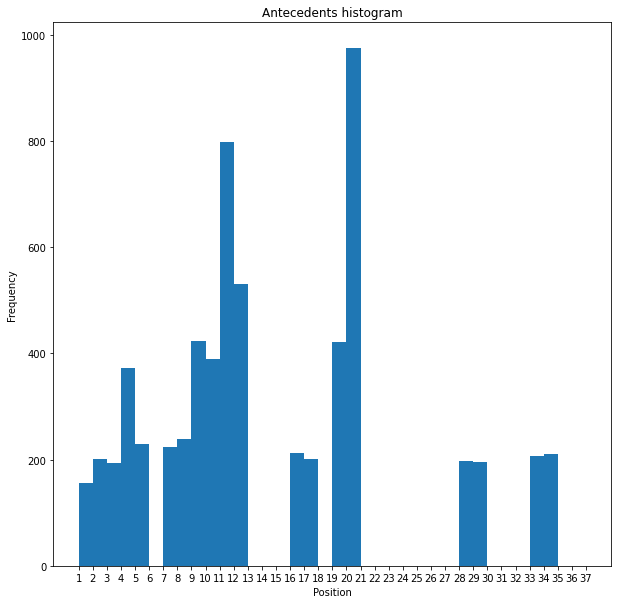

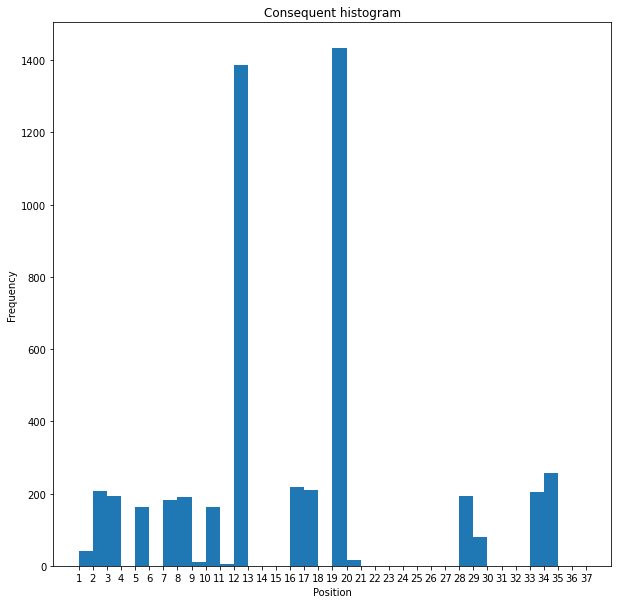

In [111]:
# Codon file

pd.set_option('max_columns', 10, 'display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt


param_dict = {  
    "in_file": "https://raw.githubusercontent.com/kxk302/HIV/main/data/HIV_V3.fas_AA_macse_pre_tra.tsv",
    "min_support": 0.050, 
    "min_confidence": 0.500, 
    "min_lift": 2.0, 
    "min_conviction": 2.0, 
    "max_len": 4,
    "codon": False
}

hiv_rules = get_association_rules_param(param_dict)

# Filter rules based on distance between head and tail positions
# Only valid is max_len is 2
# hiv_rules = filter_rules_based_on_distance(hiv_rules, 1)

num_rules = hiv_rules.shape[0]
hiv_rules = hiv_rules.sort_values('conviction', ascending=False)
# hiv_rules_sorted = hiv_rules.sort_values('distance', ascending=False)
print('Number of rules: {}'.format(num_rules))
print('HIV dataset association rules: ')
# print(hiv_rules_sorted.head(num_rules))
print(hiv_rules.head(num_rules))

# Histogram of positions in head and tail of rules
ante_hist_list = get_histogram_list(hiv_rules.iloc[:,0])
cons_hist_list = get_histogram_list(hiv_rules.iloc[:,1])

print(set(ante_hist_list))
print(set(cons_hist_list))

bins = list(range(1,38,1))

plot1 = plt.figure(1)
plot1.set_size_inches(10,10)
plt.title('Antecedents histogram')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.xticks(list(range(1,38)))
plt.hist(sorted(ante_hist_list), bins=bins)

plot2 = plt.figure(2)
plot2.set_size_inches(10,10)
plt.title('Consequent histogram')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.xticks(list(range(1,38)))
plt.hist(sorted(cons_hist_list),  bins=bins)


In [ ]:
plt.hist(sorted(ante_hist_list), 36)plt.hist(a_list, 5)!ls

HIV_V3_codonmsa_macse_pre.tsv  sample_data


In [ ]:
!more HIV_V3_codonmsa_macse_pre.tsv

Sample	Nucleotide	Position
0	T	2
1	C	2
2	C	2
3	C	2
4	C	2
5	T	2
6	C	2
7	T	2
8	T	2
9	C	2
10	T	2
11	C	2
12	C	2
13	C	2
14	C	2
15	C	2
16	C	2
17	T	2
18	T	2
19	C	2
20	T	2
21	T	2


In [ ]:
dd = pd.read_csv('HIV_V3_codonmsa_macse_pre.tsv',sep='\t')

In [ ]:
preprocess_input_file(dd)

Label,A10,A11,A12,A123,A124,...,T83,T84,T85,T86,T9
Sample,,,,,,,,,,,
0,0,1,0,0,0,...,0,0,0,0,0
1,0,1,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,1,0
4,0,0,0,0,0,...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1351,1,0,0,0,0,...,1,0,0,0,0
1352,0,1,0,0,0,...,0,0,1,0,0
1353,0,1,0,0,0,...,0,0,1,0,0
